In [12]:
# Import Pytorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib
import matplotlib.pyplot as plt
device = "cpu" if torch.backends.mps.is_available() else "cpu"
device


'cpu'

In [13]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download the data
    train=True, # get training data
    download=True, # download if not present
    transform=ToTensor(), # images come as PIL format, we need to convert them to Torch tensors
    target_transform=None # labels can also be transformed but in this dataset they are already in the right format        
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [14]:
# See firt training sample
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [15]:
# What is the shape of the image?
image.shape

torch.Size([1, 28, 28])

In [16]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)


(60000, 60000, 10000, 10000)

In [17]:
# See class names
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


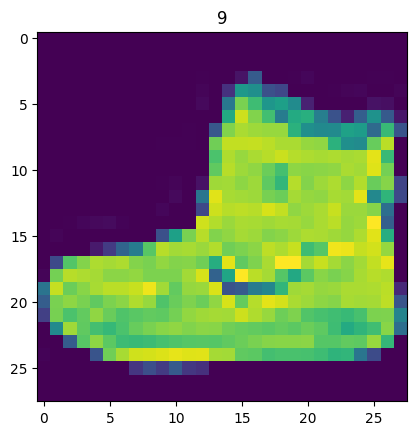

In [18]:
# Let's visualize the data
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # squeeze removes the extra dimension, image shape is [1, 28, 28]
plt.title(label);

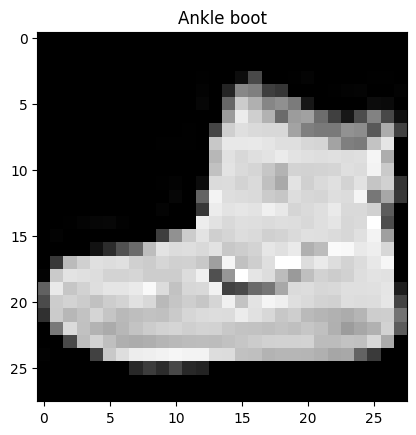

In [19]:
# We can turn this into grayscale using cmap parameter of plt.imshow()
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

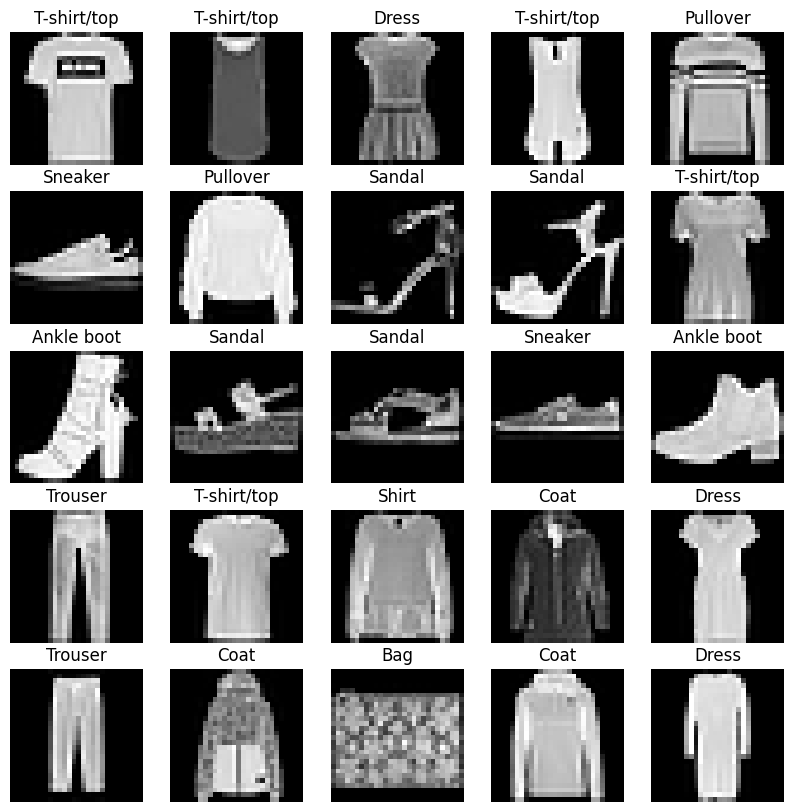

In [20]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(10, 10))
rows, cols = 5, 5
for i in range(1, rows * cols + 1):
    image, label = train_data[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis("off")

In [21]:
# Let's create DataLoader for our training and testing data

from torch.utils.data import DataLoader

#Setup the batch size 
BATCH_SIZE = 64
# Apple Silicon need this function to make sure the data is on the same device
generator = torch.Generator(device=device)
# Turn datasets into batches

train_Dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              generator=generator)

test_dataloader = DataLoader(test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            generator=generator)

# Let's take a look at one batch
print(f"Dataloaders: {train_Dataloader, test_dataloader}")
print(f" Length of train dataloader: {len(train_Dataloader)} batches of {BATCH_SIZE} samples each")
print(f" Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} samples each")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x11d7ae350>, <torch.utils.data.dataloader.DataLoader object at 0x11da5d010>)
 Length of train dataloader: 938 batches of 64 samples each
 Length of test dataloader: 157 batches of 64 samples each


In [22]:
# Check out what's inside the training dataloader

train_features_batch, train_labels_batch = next(iter(train_Dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

Image size: torch.Size([1, 28, 28])
Label: 3, label size: torch.Size([])


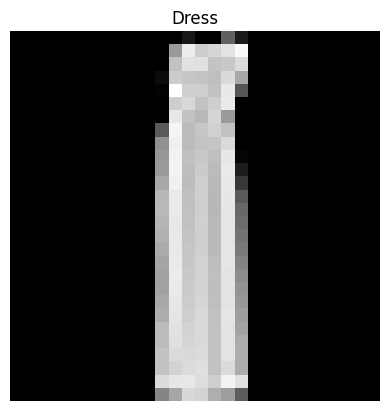

In [23]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [24]:
# Start to build a simple model
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.model_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.model_layers(x)
    

In [25]:
torch.manual_seed(42)

# Create model
model_0 = FashionMNISTModelV0(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names))
model_0.to("cpu") # keep model on CPU to begin with

FashionMNISTModelV0(
  (model_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [27]:
# Import accuracy metrics. We can either use accuracy_fn from helper_functions or use torchmetrics
from helper_functions import accuracy_fn as accuracy_fn2
from torchmetrics.classification import MulticlassAccuracy
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to("cpu")

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [28]:
# Define a function to time our experiments
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [30]:
# Building the training loop
#import tqdm for progress bar
from tqdm.auto import tqdm

# set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epohs 
epochs = 15

# Create training an testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------------------------------")
    ###Training
    train_loss = 0
    # Add a loop to loop trhough training batches
    for batch, (X, y) in enumerate(train_Dataloader):
        model_0.train()
        # 1. forward pass
        y_pred = model_0(X)
        
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/ {len(train_Dataloader.dataset)} samples")
    # Divide total train loss by length of train dataloader  (average loss per batch per epoch)
    train_loss /= len(train_Dataloader)
    
    ###Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
            
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y)
            
            # Calculate accuracy 
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        #Calculations on test metrics need to happen inside torch.inference_mode()
        #Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)
        
        #Divide total test accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)
        
    ##Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}\n")
    
# Calculate total train and test time
train_time_end_on_cpu = timer()
total_training_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                               end=train_time_end_on_cpu, 
                                               device=str(next(model_0.parameters()).device))

/Users/denizkonuk/Pytorch/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


  7%|▋         | 1/15 [00:01<00:20,  1.47s/it]


Train loss: 0.63263 | Test loss: 0.52732, Test acc: 0.82

Epoch: 1
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 13%|█▎        | 2/15 [00:02<00:18,  1.46s/it]


Train loss: 0.48098 | Test loss: 0.49740, Test acc: 0.83

Epoch: 2
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 20%|██        | 3/15 [00:04<00:17,  1.44s/it]


Train loss: 0.45633 | Test loss: 0.50090, Test acc: 0.83

Epoch: 3
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 27%|██▋       | 4/15 [00:05<00:15,  1.44s/it]


Train loss: 0.44156 | Test loss: 0.52966, Test acc: 0.82

Epoch: 4
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 33%|███▎      | 5/15 [00:07<00:14,  1.44s/it]


Train loss: 0.43292 | Test loss: 0.48050, Test acc: 0.83

Epoch: 5
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 40%|████      | 6/15 [00:08<00:13,  1.45s/it]


Train loss: 0.42683 | Test loss: 0.46842, Test acc: 0.83

Epoch: 6
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 47%|████▋     | 7/15 [00:10<00:11,  1.44s/it]


Train loss: 0.41941 | Test loss: 0.46776, Test acc: 0.84

Epoch: 7
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 53%|█████▎    | 8/15 [00:11<00:10,  1.43s/it]


Train loss: 0.41615 | Test loss: 0.47016, Test acc: 0.83

Epoch: 8
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 60%|██████    | 9/15 [00:12<00:08,  1.43s/it]


Train loss: 0.41354 | Test loss: 0.57568, Test acc: 0.83

Epoch: 9
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 67%|██████▋   | 10/15 [00:14<00:07,  1.43s/it]


Train loss: 0.41192 | Test loss: 0.44880, Test acc: 0.84

Epoch: 10
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 73%|███████▎  | 11/15 [00:15<00:05,  1.44s/it]


Train loss: 0.40651 | Test loss: 0.56265, Test acc: 0.81

Epoch: 11
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 80%|████████  | 12/15 [00:17<00:04,  1.44s/it]


Train loss: 0.40663 | Test loss: 0.44911, Test acc: 0.84

Epoch: 12
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 87%|████████▋ | 13/15 [00:18<00:02,  1.44s/it]


Train loss: 0.40294 | Test loss: 0.45098, Test acc: 0.84

Epoch: 13
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


 93%|█████████▎| 14/15 [00:20<00:01,  1.43s/it]


Train loss: 0.40083 | Test loss: 0.45392, Test acc: 0.84

Epoch: 14
-------------------------------
Looked at 0/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 51200/ 60000 samples


100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


Train loss: 0.40007 | Test loss: 0.53640, Test acc: 0.83

Train time on cpu: 21.572 seconds


In [31]:
torch.manual_seed(42)
from torchmetrics.classification import MulticlassAccuracy
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn: MulticlassAccuracy):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
        
            acc += accuracy_fn2(y, y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn2
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5394126176834106,
 'model_acc': 79.60788216560509}

In [32]:
# Change the devide to gpu
device = "mps" if torch.backends.mps.is_available() else "cpu"
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
device

'mps'

In [33]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.model_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.model_layers(x)

In [34]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names))
model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

In [35]:
# Setup loss, optimizer and evaluation metrics
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr=0.1)
                            

In [36]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        
        # 1 Forward pass
        y_pred = model(X)
        
        # 2. Calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))
            
            # Adjust metrics and print out
            test_loss /= len(data_loader)
            test_acc /= len(data_loader)
            print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

        

In [37]:
torch.manual_seed(42)

#Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------------------------------")
    train_step(data_loader=train_Dataloader,
               model=model_1,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn2)
    test_step(data_loader=test_dataloader,
              model=model_1,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn2)
    
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------------------------------
Train loss: 1.10813 | Train accuracy: 61.28%
Test loss: 0.00836 | Test accuracy: 0.38%
Test loss: 0.00835 | Test accuracy: 0.34%
Test loss: 0.00893 | Test accuracy: 0.33%
Test loss: 0.00766 | Test accuracy: 0.38%
Test loss: 0.00831 | Test accuracy: 0.35%
Test loss: 0.00705 | Test accuracy: 0.37%
Test loss: 0.00683 | Test accuracy: 0.39%
Test loss: 0.00874 | Test accuracy: 0.31%
Test loss: 0.00931 | Test accuracy: 0.32%
Test loss: 0.00787 | Test accuracy: 0.36%
Test loss: 0.00761 | Test accuracy: 0.35%
Test loss: 0.00608 | Test accuracy: 0.38%
Test loss: 0.00834 | Test accuracy: 0.33%
Test loss: 0.00952 | Test accuracy: 0.29%
Test loss: 0.00899 | Test accuracy: 0.31%
Test loss: 0.00736 | Test accuracy: 0.32%
Test loss: 0.00715 | Test accuracy: 0.38%
Test loss: 0.00858 | Test accuracy: 0.35%
Test loss: 0.00701 | Test accuracy: 0.36%
Test loss: 0.00758 | Test accuracy: 0.35%
Test loss: 0.00978 | Test accuracy: 0.30%
Test loss: 0.00576 | Test accura

 33%|███▎      | 1/3 [00:03<00:07,  3.58s/it]

Test loss: 0.00893 | Test accuracy: 0.31%
Test loss: 0.00994 | Test accuracy: 0.30%
Test loss: 0.00694 | Test accuracy: 0.37%
Test loss: 0.00823 | Test accuracy: 0.38%
Test loss: 0.00245 | Test accuracy: 0.60%
Epoch: 1
-------------------------------
Train loss: 0.92426 | Train accuracy: 66.28%
Test loss: 0.00639 | Test accuracy: 0.42%
Test loss: 0.00570 | Test accuracy: 0.43%
Test loss: 0.00464 | Test accuracy: 0.46%
Test loss: 0.00575 | Test accuracy: 0.46%
Test loss: 0.00808 | Test accuracy: 0.34%
Test loss: 0.00690 | Test accuracy: 0.41%
Test loss: 0.00657 | Test accuracy: 0.40%
Test loss: 0.00674 | Test accuracy: 0.40%
Test loss: 0.00603 | Test accuracy: 0.43%
Test loss: 0.00770 | Test accuracy: 0.34%
Test loss: 0.00627 | Test accuracy: 0.40%
Test loss: 0.00565 | Test accuracy: 0.46%
Test loss: 0.00826 | Test accuracy: 0.35%
Test loss: 0.00676 | Test accuracy: 0.40%
Test loss: 0.00497 | Test accuracy: 0.47%
Test loss: 0.00675 | Test accuracy: 0.36%
Test loss: 0.00590 | Test accura

 67%|██████▋   | 2/3 [00:06<00:03,  3.44s/it]

Test loss: 0.00707 | Test accuracy: 0.41%
Test loss: 0.00538 | Test accuracy: 0.46%
Test loss: 0.00444 | Test accuracy: 0.48%
Epoch: 2
-------------------------------
Train loss: 0.89042 | Train accuracy: 67.14%
Test loss: 0.00764 | Test accuracy: 0.36%
Test loss: 0.00638 | Test accuracy: 0.41%
Test loss: 0.00783 | Test accuracy: 0.37%
Test loss: 0.00979 | Test accuracy: 0.34%
Test loss: 0.00886 | Test accuracy: 0.33%
Test loss: 0.00659 | Test accuracy: 0.39%
Test loss: 0.00787 | Test accuracy: 0.35%
Test loss: 0.00637 | Test accuracy: 0.39%
Test loss: 0.00650 | Test accuracy: 0.43%
Test loss: 0.00741 | Test accuracy: 0.40%
Test loss: 0.00608 | Test accuracy: 0.42%
Test loss: 0.00659 | Test accuracy: 0.45%
Test loss: 0.00653 | Test accuracy: 0.36%
Test loss: 0.00692 | Test accuracy: 0.40%
Test loss: 0.00797 | Test accuracy: 0.35%
Test loss: 0.00572 | Test accuracy: 0.45%
Test loss: 0.00671 | Test accuracy: 0.36%
Test loss: 0.00902 | Test accuracy: 0.35%
Test loss: 0.00743 | Test accura

100%|██████████| 3/3 [00:10<00:00,  3.42s/it]

Test loss: 0.00933 | Test accuracy: 0.35%
Test loss: 0.00773 | Test accuracy: 0.36%
Test loss: 0.00970 | Test accuracy: 0.31%
Test loss: 0.00740 | Test accuracy: 0.43%
Test loss: 0.00648 | Test accuracy: 0.40%
Train time on mps: 10.261 seconds


In [ ]:
torch.manual_seed(42)

# Note: This will error due to `eval_model()` not using device agnostic code 
model_1_results = eval_model_gpu(model=model_1, 
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn) 
model_1_results 

RuntimeError: Tensor for argument input is on cpu but expected on mps

In [38]:
# Let's create a Convulational Model

class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.model_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.model_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units,
                      hidden_units,
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, 
                      hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
        
    def forward(self, x: torch.Tensor):
        x = self.model_block_1(x)
        print(x.shape)
        x= self.model_block_2(x)
        print(x.shape)
        x = self.classifier(x)
        return x

model_2 = FashionMNISTModelV2(input_shape=1,
                             hidden_units=32,
                             output_shape=10).to(device)
print(model_2)

FashionMNISTModelV2(
  (model_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (model_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
  )
)


In [39]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [40]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_Dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn2,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn2,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
torch.Size([64, 32, 14, 14])


 33%|███▎      | 1/3 [00:06<00:12,  6.45s/it]

Test loss: 0.00220 | Test accuracy: 0.57%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00256 | Test accuracy: 0.54%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00158 | Test accuracy: 0.59%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00314 | Test accuracy: 0.50%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00335 | Test accuracy: 0.51%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00223 | Test accuracy: 0.56%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00488 | Test accuracy: 0.47%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00255 | Test accuracy: 0.53%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00308 | Test accuracy: 0.50%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00193 | Test accuracy: 0.58%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00178 |

 67%|██████▋   | 2/3 [00:12<00:05,  5.98s/it]

torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00182 | Test accuracy: 0.59%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00185 | Test accuracy: 0.56%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00214 | Test accuracy: 0.59%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00282 | Test accuracy: 0.57%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00174 | Test accuracy: 0.55%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00318 | Test accuracy: 0.56%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00340 | Test accuracy: 0.53%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00284 | Test accuracy: 0.51%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00237 | Test accuracy: 0.55%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00178 | Test accuracy: 0.58%
torch.Size([64, 32, 

100%|██████████| 3/3 [00:17<00:00,  5.91s/it]

torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00239 | Test accuracy: 0.55%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00211 | Test accuracy: 0.54%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00168 | Test accuracy: 0.58%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00175 | Test accuracy: 0.57%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00152 | Test accuracy: 0.58%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00408 | Test accuracy: 0.53%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00296 | Test accuracy: 0.54%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00175 | Test accuracy: 0.56%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00178 | Test accuracy: 0.56%
torch.Size([64, 32, 14, 14])
torch.Size([64, 32, 7, 7])
Test loss: 0.00157 | Test accuracy: 0.59%
torch.Size([64, 32, 

In [41]:
torch.manual_seed(42)
from torchmetrics.classification import MulticlassAccuracy
def eval_model_gpu(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device: torch.device = device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
        
            acc += accuracy_fn2(y, y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}



In [42]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

RuntimeError: Mismatched Tensor types in NNPack convolutionOutput